In [1]:
%pip install nlpaug

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("nli_train.csv", nrows=None, low_memory=False).reset_index(drop=True)
test_df = pd.read_csv("nli_test.csv", nrows=None, low_memory=False).reset_index(drop=True)
val_df = pd.read_csv("nli_val.csv", nrows=None, low_memory=False).reset_index(drop=True)

In [15]:
counts = raw_df.l1.value_counts()
items = [(name, f"{count:,}") for name, count in counts.items()]
for i in range(0, len(items), 2):
    if i + 1 < len(items):
        # Two items on this line
        print(f"{items[i][0]} & {items[i][1]} & {items[i+1][0]} & {items[i+1][1]} \\\\")
    else:
        # Only one item left
        print(f"{items[i][0]} & {items[i][1]} & & \\\\")

Germany & 65,593 & Russia & 64,549 \\
Netherlands & 47,929 & United Kingdom & 42,444 \\
Serbia & 36,004 & United States & 31,326 \\
Poland & 30,266 & Sweden & 30,181 \\
Finland & 29,372 & Italy & 27,071 \\
Ireland & 24,530 & Spain & 23,965 \\
France & 23,735 & Norway & 19,461 \\
North Macedonia & 18,793 & Austria & 18,360 \\
Bosnia and Herzegovina & 18,065 & Denmark & 18,010 \\
Romania & 17,503 & Belgium & 16,094 \\
Portugal & 16,055 & Croatia & 12,707 \\
Hungary & 12,334 & Greece & 11,216 \\
England & 10,937 & Czechia & 10,418 \\
Scotland & 10,106 & China & 9,491 \\
Switzerland & 9,482 & Turkey & 9,381 \\
Slovakia & 7,333 & Bulgaria & 7,247 \\
Slovenia & 7,109 & Ukraine & 6,637 \\
Lithuania & 5,902 & Estonia & 5,140 \\
Czech Republic & 4,313 & Wales & 4,161 \\
Canada & 3,630 & Latvia & 3,509 \\
Japan & 3,490 & Montenegro & 3,273 \\
Australia & 3,008 & Cyprus & 2,422 \\
Iceland & 2,399 & Luxembourg & 2,339 \\
South Korea & 2,285 & Kazakhstan & 2,063 \\
Vietnam & 1,780 & Argentina & 1,4

In [5]:
len(train_df.l1.unique())

90

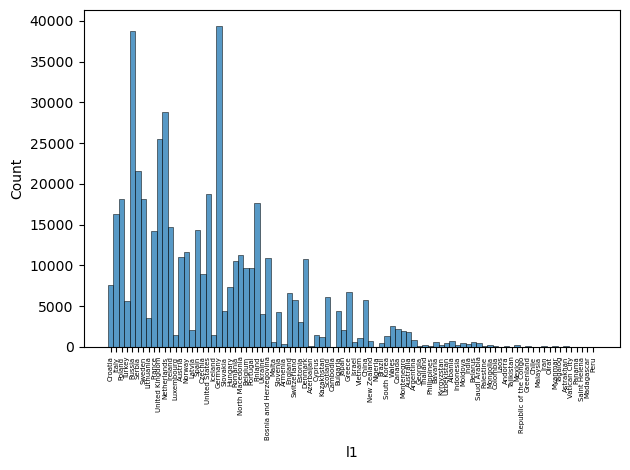

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# l1 histplot with rotated xticks
def dist(df):
    ax = sns.histplot(df, x="l1", multiple="layer")
    plt.xticks(rotation=90)
    plt.xticks(fontsize=5)
    plt.tight_layout()
    plt.show()
dist(train_df)

In [8]:
def remove_noise(df):
    # remove rows where sentences have less than 4 words
    df = df[df['sentence'].apply(lambda x: len(x.split()) > 4)]
    df.sentence = df.sentence.str.replace(" ,", ",")
    df.sentence = df.sentence.str.replace(" .", ".")
    df.sentence = df.sentence.str.replace("  ", " ")
    return df

In [9]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import random

noise_aug = nac.KeyboardAug(
    aug_char_min=1,
    aug_char_max=1,
)

del_aug = nac.RandomCharAug(
    action="delete",
    aug_char_min=1,
    aug_char_max=2,
)

wdel_aug = naw.RandomWordAug(action="delete", aug_p=0.05)


def upsample_group_to_target_kb(group, target_size=1000):

    if len(group) >= target_size:
        return group

    current_group = group.copy()
    original_group = group.copy()  # Keep original data for augmentation source

    while len(current_group) < target_size:
        needed = target_size - len(current_group)
        augmentations_to_create = min(needed, len(original_group))

        # Always augment from original data
        rows_to_augment = original_group.sample(n=augmentations_to_create, replace=True)
        augmented_data = []

        for _, row in rows_to_augment.iterrows():
            choice = random.randint(0, 2)
            match choice:
                case 0:
                    augmented_text = del_aug.augment(row['sentence'])
                case 1:
                    augmented_text = noise_aug.augment(row['sentence'])
                case 2:
                    augmented_text = wdel_aug.augment(row['sentence'])
            if isinstance(augmented_text, list):
                augmented_text = augmented_text[0]
            augmented_data.append({
                'sentence': str(augmented_text),
                'l1': row['l1']
            })

        current_group = pd.concat(
            [current_group, pd.DataFrame(augmented_data)], ignore_index=True)

    return current_group

def upsame_minorities(df):
    df = df.groupby('l1').apply(upsample_group_to_target_kb).reset_index(drop=True)
    return df

/tmp/ipykernel_92/601065204.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('l1').apply(upsample_group_to_target_kb).reset_index(drop=True)


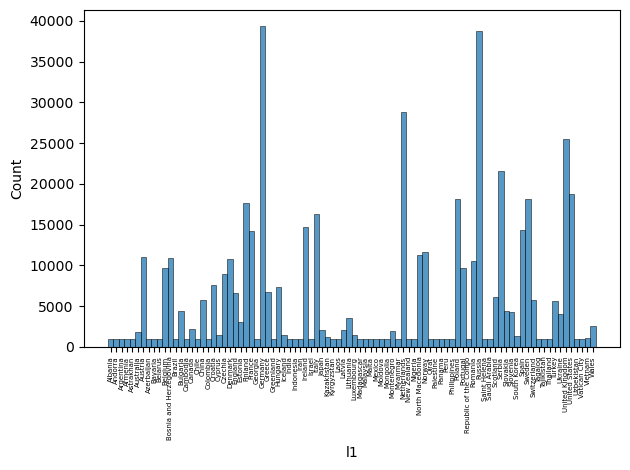

In [10]:
train_df = remove_noise(train_df)
train_df = upsame_minorities(train_df)
dist(train_df)

In [11]:
train_df.to_csv("nli_train_upsampled.csv", index=False)